In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [2]:
b_modes = 3
t_modes = 3

## Create Now
#AM = rwm.AeroModelClass(drag = True,stall = True,rot = True)
#sm,p = rwm.GenV2RectWing(b_modes,t_modes,AM,iwt=True,iwb=True,fixed_root = False)

## Laod from file
p = rw.base_params(b_modes+t_modes+2)
sm = mf.SymbolicModel.from_file('3B3T-M5.py')

In [144]:
p.rho.value = 1.225
p.s_t.value = 1.345
p.c.value = 0.15
p.EI.value = 61
p.GJ.value = 200
p.rho_t.value = 10
p.e_0.value = 0
p.e_1.value = 0
p.ratio_fwt.value = 0.2
p.alpha_s.value = np.deg2rad(15)
p.eta.value = [1]*p.qs
p.m_ac.value = 1e6
p.k_ac.value = 1e6

variables = [p.V,p.alpha_r,p.c_dmax,p.m_factor,p.Lambda,p.w_g,p.k_fwt,p.yaw]

sm_mini = sm.msubs({**p.GetSubs(None,None,ignore = variables),p.q[0]:0,p.qd[0]:0})
nm = sm_mini.CreateNumericModel(p)
def Reduced_eqn(model):      
    f =  me.msubs(model.f-model.ExtForces.Q(),{i:0 for i in p.qd})
    f = sym.Matrix([0,*f[1:]])
    return f
#f = me.msubs((sm_mini.f-sm_mini.ExtForces.Q()),{i:0 for i in p.qd})
f = Reduced_eqn(sm_mini)
func_obj = sym.lambdify((p.q,variables),f,"numpy") 
func_obj_jac = sym.lambdify((p.q,variables),f.jacobian(p.q),"numpy") 

In [149]:
p.V.value = 10
p.alpha_r.value = np.deg2rad(5)
p.c_dmax.value = 1
p.m_factor.value = 0.5
p.Lambda.value = np.deg2rad(10)
p.w_g.value = 0
p.k_fwt.value = 0
p.yaw.value = np.deg2rad(0)

values = [i.value for i in variables]




In [150]:
%%time
guess=[0]*(p.qs-1)
guess[-1] = 0
q = np.array([0]+list(fsolve(lambda q,v:func_obj([0]+list(q),values)[1:,0],guess,args=(values,),factor = 1)))
q

CPU times: user 2.39 ms, sys: 19 µs, total: 2.4 ms
Wall time: 2.39 ms


array([ 0.00000000e+00, -5.55903432e-02,  3.12658526e-02, -6.52717726e-03,
        2.95745426e-03, -1.37428172e-03,  6.14021195e-17,  1.01488483e+00])

In [151]:
%%time
guess=[0]*(p.qs)
#guess[-1] = np.pi/2
def FuncReduced(q,values):
    res = func_obj(q,values)
    res[0] = 0
    return res
q = np.array(fsolve(lambda q:FuncReduced(q,values)[:,0],guess,factor = 1))

q

CPU times: user 2.54 ms, sys: 50 µs, total: 2.59 ms
Wall time: 2.57 ms


array([ 0.00000000e+00, -5.55903432e-02,  3.12658526e-02, -6.52717726e-03,
        2.95745426e-03, -1.37428172e-03,  6.14021195e-17,  1.01488483e+00])

In [166]:
%%time
guess=[0]*(p.qs)
guess[-1] = 0.1
q[-1] += -0.1
from scipy.optimize import least_squares
least_squares(lambda q,v:func_obj(q,values)[:,0],q,method='dogbox',loss = 'linear',jac=func_obj_jac,args = (values,)).x

CPU times: user 2.96 ms, sys: 933 µs, total: 3.9 ms
Wall time: 3.02 ms


array([ 0.00000000e+00, -5.55903432e-02,  3.12658526e-02, -6.52717726e-03,
        2.95745426e-03, -1.37428172e-03,  5.43588287e-17,  1.01488483e+00])

In [26]:
%%time
p.V.value = 20
p.w_g.value = 0
p.m_factor.value = 0.5
p.k_fwt.value = 0
p.Lambda.value = np.deg2rad(10)
p.alpha_r.value = np.deg2rad(7)

b_shapes = 3

z,_ = mf.ShapeFunctions_BN_TM(b_shapes,0,p.q[1:b_shapes+1],p.y_0,0,0,0,p.eta[1:b_shapes+1])

d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)


values = [i.value for i in variables]
guess = [0]*(p.qs-1)

q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

print(np.rad2deg(dz_dy_tip_f(p.GetNumericTuple(q,0),q)))

def gust(t,x):
    T = 1
    if t<T:
        return 0.5*(1- np.cos(2*np.pi*t/T))
    else:
        return 0
    
p.w_g.value = gust
def objectiveDeriv(t,y):
    tup = p.GetNumericTuple(y,t)
    deriv = list(nm.deriv(t,y,tup))    
    #deriv[0] = deriv[1] = 0
    return tuple(deriv)
    
    

x0 = [0]*p.qs*2
x0[::2]=q


3.170437435299744
CPU times: user 45.1 ms, sys: 2.14 ms, total: 47.2 ms
Wall time: 46.7 ms


In [27]:
%%time
q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

CPU times: user 1.73 ms, sys: 18 µs, total: 1.75 ms
Wall time: 1.74 ms


In [28]:
x = [0]*p.qs*2
x[::2]=q
nm.deriv(0,x,p.GetNumericTuple(x,0))

In [29]:
%%time
yData = solve_ivp(objectiveDeriv,(0,5),x)

CPU times: user 16.3 s, sys: 118 ms, total: 16.4 s
Wall time: 16.6 s


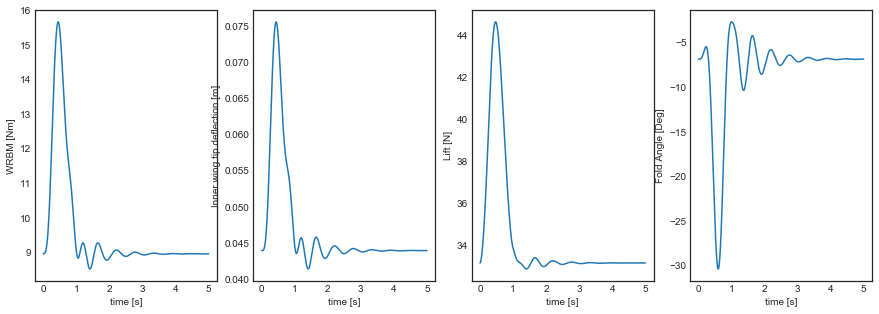

In [30]:
yi = yData.y
t = yData.t

b_shapes = 3
d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)

lift = []
for i in range(len(t)):
    lift.append(nm.ExtForces(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i],t[i])[0])

plt.style.use('seaborn-white')

tup = p.GetNumericTuple([0]*p.qs*2,0)

fig, axes = plt.subplots(1,4,figsize=(15,5))
axes[0].plot(t,d2z_dy2_f(tup,yi[::2])*p.EI.value)
axes[0].set_ylabel('WRBM [Nm]')
axes[0].set_xlabel('time [s]')

axes[1].plot(t,z_tip_f(tup,yi[::2]))
axes[1].set_ylabel('Inner wing tip deflection [m]')
axes[1].set_xlabel('time [s]')

axes[2].plot(t,lift)
axes[2].set_ylabel('Lift [N]')
axes[2].set_xlabel('time [s]')

axes[3].plot(t,np.rad2deg((yi[-2])+dz_dy_tip_f(tup,yi[::2])))
axes[3].set_ylabel('Fold Angle [Deg]')
axes[3].set_xlabel('time [s]')

yi[::2].shape